<a href="https://colab.research.google.com/github/TobyChen320/DS-Unit-2-Applied-Modeling/blob/master/Toby_Chen_DSPT6_Applied_Modeling_4_NBA_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
%matplotlib inline
!pip install category_encoders==2.*
!pip install pdpbox
!pip install shap

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import category_encoders as ce
import graphviz
from sklearn.tree import export_graphviz
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import f_regression, SelectKBest
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform
from sklearn.tree import DecisionTreeClassifier

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [5]:
import pandas as pd
df = pd.read_csv('/content/drive/My Drive/Data/all_seasons.csv', index_col = 0)
df.head()

,player_name,team_abbreviation,age,player_height,player_weight,college,country,draft_year,draft_round,draft_number,gp,pts,reb,ast,net_rating,oreb_pct,dreb_pct,usg_pct,ts_pct,ast_pct,season
0,Dennis Rodman,CHI,36.0,198.12,99.790240,Southeastern Oklahoma State,USA,1986,2,27,55,5.7,16.1,3.1,16.1,0.186,0.323,0.100,0.479,0.113,1996-97
1,Dwayne Schintzius,LAC,28.0,215.90,117.933920,Florida,USA,1990,1,24,15,2.3,1.5,0.3,12.3,0.078,0.151,0.175,0.430,0.048,1996-97
2,Earl Cureton,TOR,39.0,205.74,95.254320,Detroit Mercy,USA,1979,3,58,9,0.8,1.0,0.4,-2.1,0.105,0.102,0.103,0.376,0.148,1996-97
3,Ed O'Bannon,DAL,24.0,203.20,100.697424,UCLA,USA,1995,1,9,64,3.7,2.3,0.6,-8.7,0.060,0.149,0.167,0.399,0.077,1996-97
4,Ed Pinckney,MIA,34.0,205.74,108.862080,Villanova,USA,1985,1,10,27,2.4,2.4,0.2,-11.2,0.109,0.179,0.127,0.611,0.040,1996-97


In [6]:
%matplotlib inline
!pip install category_encoders==2.*
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import category_encoders as ce
import graphviz
from sklearn.tree import export_graphviz
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import f_regression, SelectKBest
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform
from sklearn.tree import DecisionTreeClassifier

In [7]:
df['net_rating'].describe()

count    11145.000000
mean        -2.153899
std         12.150611
min       -200.000000
25%         -6.300000
50%         -1.300000
75%          3.200000
max        300.000000
Name: net_rating, dtype: float64

In [8]:
df = df.dropna(subset=['net_rating'])
df['Good'] = df['net_rating'] >= 1
df.head()

,player_name,team_abbreviation,age,player_height,player_weight,college,country,draft_year,draft_round,draft_number,gp,pts,reb,ast,net_rating,oreb_pct,dreb_pct,usg_pct,ts_pct,ast_pct,season,Good
0,Dennis Rodman,CHI,36.0,198.12,99.790240,Southeastern Oklahoma State,USA,1986,2,27,55,5.7,16.1,3.1,16.1,0.186,0.323,0.100,0.479,0.113,1996-97,True
1,Dwayne Schintzius,LAC,28.0,215.90,117.933920,Florida,USA,1990,1,24,15,2.3,1.5,0.3,12.3,0.078,0.151,0.175,0.430,0.048,1996-97,True
2,Earl Cureton,TOR,39.0,205.74,95.254320,Detroit Mercy,USA,1979,3,58,9,0.8,1.0,0.4,-2.1,0.105,0.102,0.103,0.376,0.148,1996-97,False
3,Ed O'Bannon,DAL,24.0,203.20,100.697424,UCLA,USA,1995,1,9,64,3.7,2.3,0.6,-8.7,0.060,0.149,0.167,0.399,0.077,1996-97,False
4,Ed Pinckney,MIA,34.0,205.74,108.862080,Villanova,USA,1985,1,10,27,2.4,2.4,0.2,-11.2,0.109,0.179,0.127,0.611,0.040,1996-97,False


In [9]:
df['Good'].value_counts(normalize=True)

False    0.630238
True     0.369762
Name: Good, dtype: float64

In [10]:
df['player_name'].nunique()

2235

In [11]:
df['player_name'].unique()

array(['Dennis Rodman', 'Dwayne Schintzius', 'Earl Cureton', ...,
       'Max Strus', 'Norvel Pelle', 'Matt Thomas'], dtype=object)

In [12]:
df['player_name'] = df['player_name'].str.lower()
cardinality = df.select_dtypes(exclude='number').nunique()
high_cardinality = cardinality[cardinality > 50].index.tolist()
high_cardinality

['player_name', 'college', 'country', 'draft_number']

In [13]:
high_cardinality.remove('player_name')
high_cardinality

['college', 'country', 'draft_number']

In [14]:
df = df.drop(columns = high_cardinality)
df.head()

,player_name,team_abbreviation,age,player_height,player_weight,draft_year,draft_round,gp,pts,reb,ast,net_rating,oreb_pct,dreb_pct,usg_pct,ts_pct,ast_pct,season,Good
0,dennis rodman,CHI,36.0,198.12,99.790240,1986,2,55,5.7,16.1,3.1,16.1,0.186,0.323,0.100,0.479,0.113,1996-97,True
1,dwayne schintzius,LAC,28.0,215.90,117.933920,1990,1,15,2.3,1.5,0.3,12.3,0.078,0.151,0.175,0.430,0.048,1996-97,True
2,earl cureton,TOR,39.0,205.74,95.254320,1979,3,9,0.8,1.0,0.4,-2.1,0.105,0.102,0.103,0.376,0.148,1996-97,False
3,ed o'bannon,DAL,24.0,203.20,100.697424,1995,1,64,3.7,2.3,0.6,-8.7,0.060,0.149,0.167,0.399,0.077,1996-97,False
4,ed pinckney,MIA,34.0,205.74,108.862080,1985,1,27,2.4,2.4,0.2,-11.2,0.109,0.179,0.127,0.611,0.040,1996-97,False


In [0]:
# Maybe random split would be better.
target = 'Good'
test = df[target]
train, val = train_test_split(df, train_size=0.80, test_size=0.20, random_state=42)

In [0]:
# train = df[(df['season'] >= '1996') & (df['season'] <= '2004')]
# val = df[(df['season'] >= '2005') & (df['season'] <= '2012')]
# test = df[(df['season'] >= '2013') & (df['season'] <= '2020')]
# train.shape, val.shape, test.shape

In [17]:
features = train.columns.drop([target, 'net_rating'])
features

Index(['player_name', 'team_abbreviation', 'age', 'player_height',
       'player_weight', 'draft_year', 'draft_round', 'gp', 'pts', 'reb', 'ast',
       'oreb_pct', 'dreb_pct', 'usg_pct', 'ts_pct', 'ast_pct', 'season'],
      dtype='object')

In [18]:
X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_train.shape, y_train.shape, X_val.shape, y_val.shape

((8916, 17), (8916,), (2229, 17), (2229,))

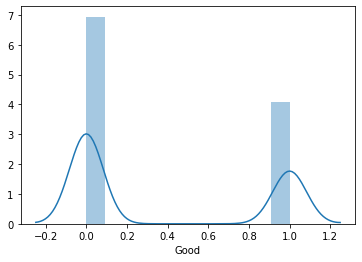

In [19]:
sns.distplot(y_train);

In [20]:
lr = make_pipeline(
    ce.TargetEncoder(),  
    LinearRegression()
)

lr.fit(X_train, y_train)
print('Linear Regression R^2', lr.score(X_val, y_val))

Linear Regression R^2 0.07968246381057509


In [21]:
coefficients = lr.named_steps['linearregression'].coef_
pd.Series(coefficients, features)

player_name          0.943847
team_abbreviation    0.469223
age                  0.001174
player_height       -0.002085
player_weight       -0.000298
draft_year           0.010210
draft_round         -0.130308
gp                   0.000621
pts                  0.002146
reb                  0.000738
ast                  0.003498
oreb_pct             0.337736
dreb_pct             0.010417
usg_pct             -0.196647
ts_pct               0.490099
ast_pct             -0.203143
season               0.887484
dtype: float64

In [22]:
from xgboost import XGBRegressor
from sklearn.metrics import r2_score

gb = make_pipeline(
    ce.OrdinalEncoder(), 
    XGBRegressor(n_estimators=200, objective='reg:squarederror', n_jobs=-1)
)

gb.fit(X_train, y_train)
y_pred = gb.predict(X_val)
print('Gradient Boosting R^2', r2_score(y_val, y_pred))

Gradient Boosting R^2 0.19340826789956878


In [0]:
from pdpbox.pdp import pdp_isolate, pdp_plot

plt.rcParams['figure.dpi'] = 72
feature = 'ts_pct'

isolated = pdp_isolate(
    model=gb,
    dataset=X_val,
    model_features=X_val.columns,
    feature=feature
)

In [25]:
y_train.mean()

0.3694481830417227

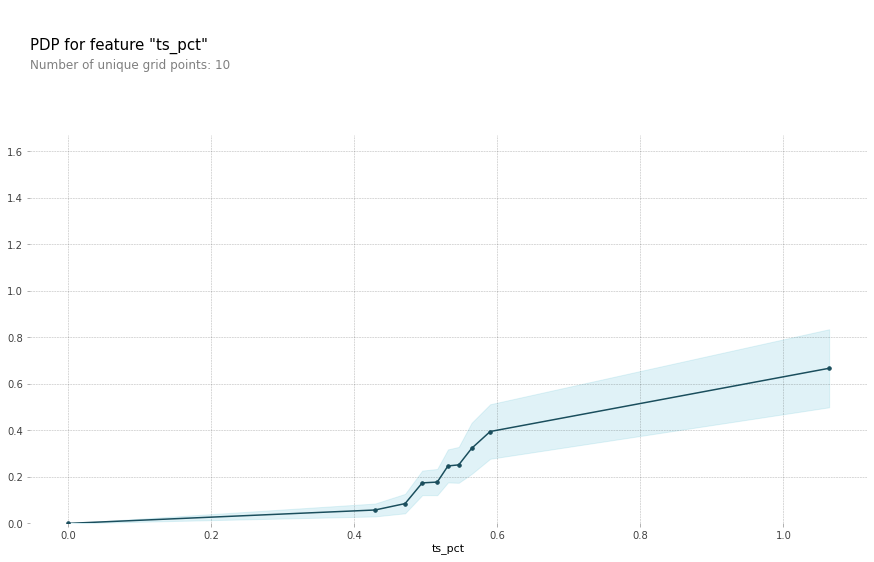

In [27]:
pdp_plot(isolated, feature_name=feature);

(<Figure size 1080x684 with 2 Axes>,
 {'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7fd156bbba90>,
  'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7fd1583fe7f0>})

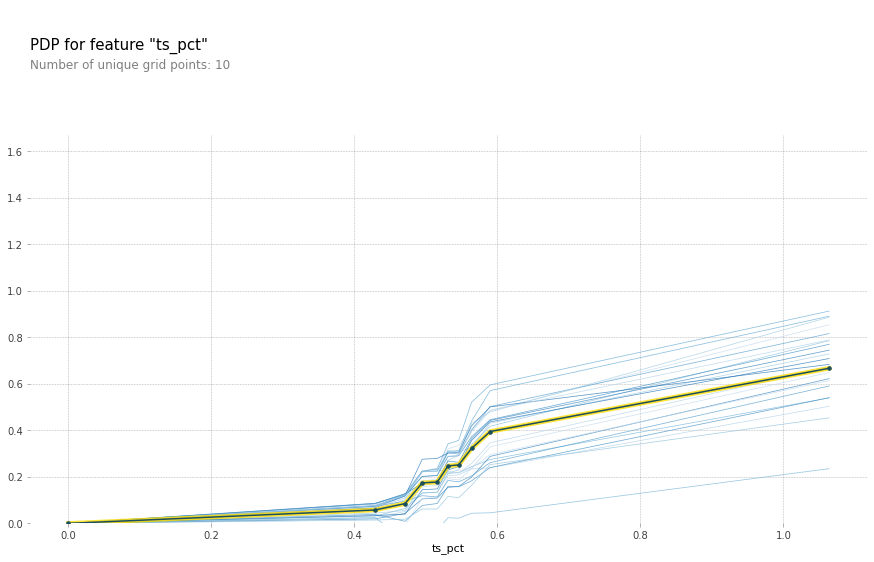

In [31]:
pdp_plot(isolated, feature_name=feature, plot_lines=True, frac_to_plot=0.01)

In [0]:
isolated = pdp_isolate(
    model=gb,
    dataset=X_val,
    model_features=X_val.columns,
    feature=feature,
    num_grid_points=25
)

In [38]:
len(X_val)*25

55725

(<Figure size 1080x684 with 2 Axes>,
 {'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7fd156b47d30>,
  'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7fd156b325f8>})

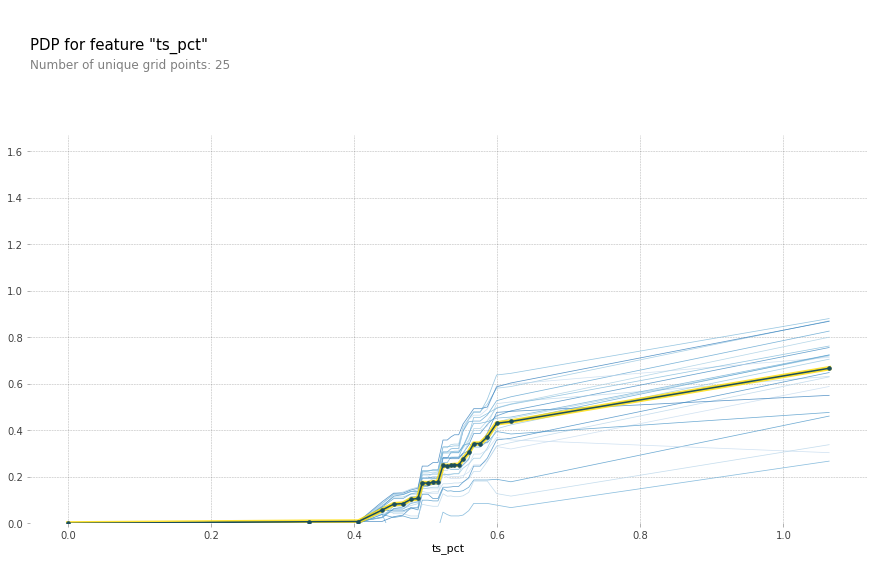

In [39]:
pdp_plot(isolated, feature_name=feature, plot_lines=True, frac_to_plot=0.01)

In [0]:
from pdpbox.pdp import pdp_interact, pdp_interact_plot

features2 = ['ts_pct', 'pts']

interact = pdp_interact(
    model=gb,
    dataset=X_val,
    model_features=X_val.columns,
    features=features2
)

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


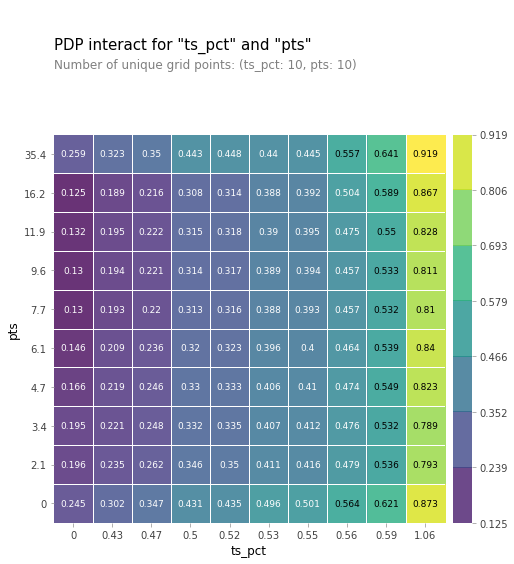

In [44]:
pdp_interact_plot(interact, plot_type='grid', feature_names=features2);

In [0]:
# Everything below this cell is seperate.
# train.groupby('player_name')[target].count().sort_values(ascending=False)

player_name
vince carter         19
paul pierce          17
tim duncan           17
chauncey billups     17
metta world peace    16
                     ..
david wear            1
david vanterpool      1
david noel            1
luke zeller           1
zylan cheatham        1
Name: Good, Length: 2124, dtype: int64

In [0]:
train_wrangled = train.groupby(['player_name', 'team_abbreviation', 'net_rating', 'season'])[target].any().reset_index()
train_wrangled.head(510)

,player_name,team_abbreviation,net_rating,season,Good
0,a.c. green,DAL,-8.0,1996-97,False
1,a.c. green,DAL,-7.2,1997-98,False
2,a.c. green,DAL,-5.6,1998-99,False
3,a.c. green,LAL,8.1,1999-00,True
4,a.c. green,MIA,3.3,2000-01,True
...,...,...,...,...,...
505,anthony johnson,NJN,4.2,2001-02,True
506,anthony johnson,ORL,-3.5,1999-00,False
507,anthony johnson,ORL,4.0,2008-09,True
508,anthony johnson,ORL,7.6,2009-10,True


In [0]:
train_wrangled.shape

(8916, 5)

In [0]:
train_wrangled[target].value_counts(normalize=True)

False    0.630552
True     0.369448
Name: Good, dtype: float64

In [0]:
players = train_wrangled[train_wrangled['Good']==True]
players

,player_name,team_abbreviation,net_rating,season,Good
3,a.c. green,LAL,8.1,1999-00,True
4,a.c. green,MIA,3.3,2000-01,True
10,aaron brooks,CHI,5.2,2014-15,True
23,aaron gray,NOH,2.2,2010-11,True
27,aaron harrison,CHA,2.2,2015-16,True
...,...,...,...,...,...
8910,zydrunas ilgauskas,CLE,2.5,2004-05,True
8911,zydrunas ilgauskas,CLE,3.8,2005-06,True
8912,zydrunas ilgauskas,CLE,4.4,1997-98,True
8913,zydrunas ilgauskas,CLE,7.9,2009-10,True


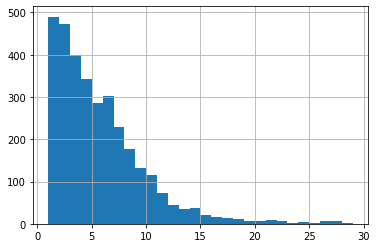

In [0]:
players['net_rating'].hist(bins=range(1, 30))

In [0]:
pipeline = make_pipeline(
    ce.ordinal.OrdinalEncoder(),
    RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
)
pipeline.fit(X_train, y_train)
print(f'Validation accuracy: {pipeline.score(X_val, y_val)}')

Validation accuracy: 0.7178106774338269


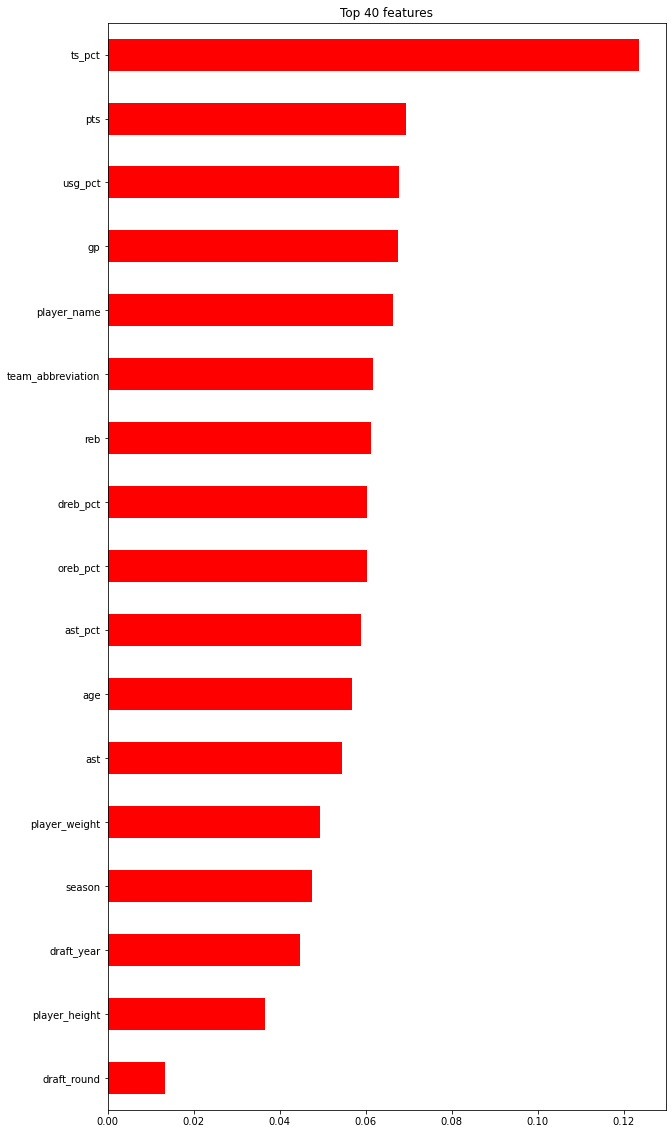

In [0]:
rf = pipeline.named_steps['randomforestclassifier']
importances = pd.Series(rf.feature_importances_, X_train.columns)
n = 40
plt.figure(figsize=(10,n/2))
plt.title(f'Top {n} features')
importances.sort_values()[-n:].plot.barh(color='red');

In [0]:
column  = 'ts_pct'

# Fit without column
pipeline = make_pipeline(
    ce.OrdinalEncoder(),  
    RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
)
pipeline.fit(X_train.drop(columns=column), y_train)
score_without = pipeline.score(X_val.drop(columns=column), y_val)
print(f'Validation Accuracy without {column}: {score_without}')

pipeline = make_pipeline(
    ce.OrdinalEncoder(),
    RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
)
pipeline.fit(X_train, y_train)
score_with = pipeline.score(X_val, y_val)
print(f'Validation Accuracy with {column}: {score_with}')

print(f'Drop-Column Importance for {column}: {score_with - score_without}')

Validation Accuracy without ts_pct: 0.702557200538358
Validation Accuracy with ts_pct: 0.7178106774338269
Drop-Column Importance for ts_pct: 0.015253476895468854


In [0]:
from xgboost import XGBClassifier

pipeline = make_pipeline(
    ce.ordinal.OrdinalEncoder(),
    XGBClassifier(n_estimators=100, random_state=42, n_jobs=-1)
)

pipeline.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['player_name', 'team_abbreviation',
                                      'draft_year', 'draft_round', 'season'],
                                drop_invariant=False, handle_missing='value',
                                handle_unknown='value',
                                mapping=[{'col': 'player_name',
                                          'data_type': dtype('O'),
                                          'mapping': zhou qi               1
paul george           2
ivica zubac           3
malcolm brogdon       4
jordan farmar         5
                   ... 
aaron holiday      2121
jamil w...
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, gamma=0, learning_rate=0.1,
                               max_delta_step=0, max_depth=3,
                

In [0]:
y_pred = pipeline.predict(X_val)
print(f'Validation accuracy: {accuracy_score(y_val, y_pred)}')

Validation accuracy: 0.7137729923732615


In [0]:
# majority_class = y_train.mode()[0]
# y_pred = [majority_class] * len(y_val)
# accuracy_score(y_val, y_pred)

0.6289816061013908

In [0]:
# y_pred = pipeline.predict_proba(X_val)[:, 1]
# roc_auc_score(y_val, y_pred)

0.5972423226794681